In [63]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import chi2_contingency

from bin import utils

In [3]:
fdata = sc.read_h5ad('./RNA/Multitime.clustered.h5')
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin100.h5')

In [4]:
def align_rna_guide_data(fdata, gdata):
    gdata.obs.marker = gdata.obs.marker.map({
        'B926-1': '2-1',
        'B926-2': '2-2',
        'B924-1': '1-1',
        'B924-2': '1-2',
        'B922-1': '3-1',
        'B922-2': '3-2'
    })
    fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
    fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
    gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]
    fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]

    common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
    fdata = fdata[common_bins].copy()
    gdata = gdata[common_bins].copy()

    gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
    return fdata, gdata
fdata, gdata = align_rna_guide_data(fdata, gdata)

In [9]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [15]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs[['marker', 'cluster']]], axis=1)

In [25]:
mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()

/tmp/ipykernel_56039/56607932.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()


In [110]:
MARKER = '2-1'
p_dict = {}

for cluster in mdf.cluster.unique():
    p_dict[cluster] = []
    for guide in mdf.variable.unique():
        if guide == 'sgnon-targeting': continue
        int_df = mdf[(mdf.marker == MARKER) & (mdf.cluster == cluster) & np.isin(mdf.variable, [guide, 'sgnon-targeting'])][['variable', 'value']].set_index('variable')
        res_df = mdf[(mdf.marker == MARKER) & (mdf.cluster != cluster) & np.isin(mdf.variable, [guide, 'sgnon-targeting'])].set_index('cluster')[['variable', 'value']].groupby('variable').sum()
        chi_df = pd.concat([int_df, res_df], axis=1)
        chi_df.columns = ['cluster_' + str(cluster), 'rest']
        pval = chi2_contingency(chi_df)[1]
        p_dict[cluster].append(pval)
chi_df = pd.DataFrame(p_dict, index=gdata.var_names[:-1]).T

In [111]:
l2fc_dict = {}

pdf = mdf[mdf.marker == MARKER].set_index(['cluster', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)
pdf = pdf.div(pdf['sgnon-targeting'], axis=0).loc[:, pdf.columns != 'sgnon-targeting']

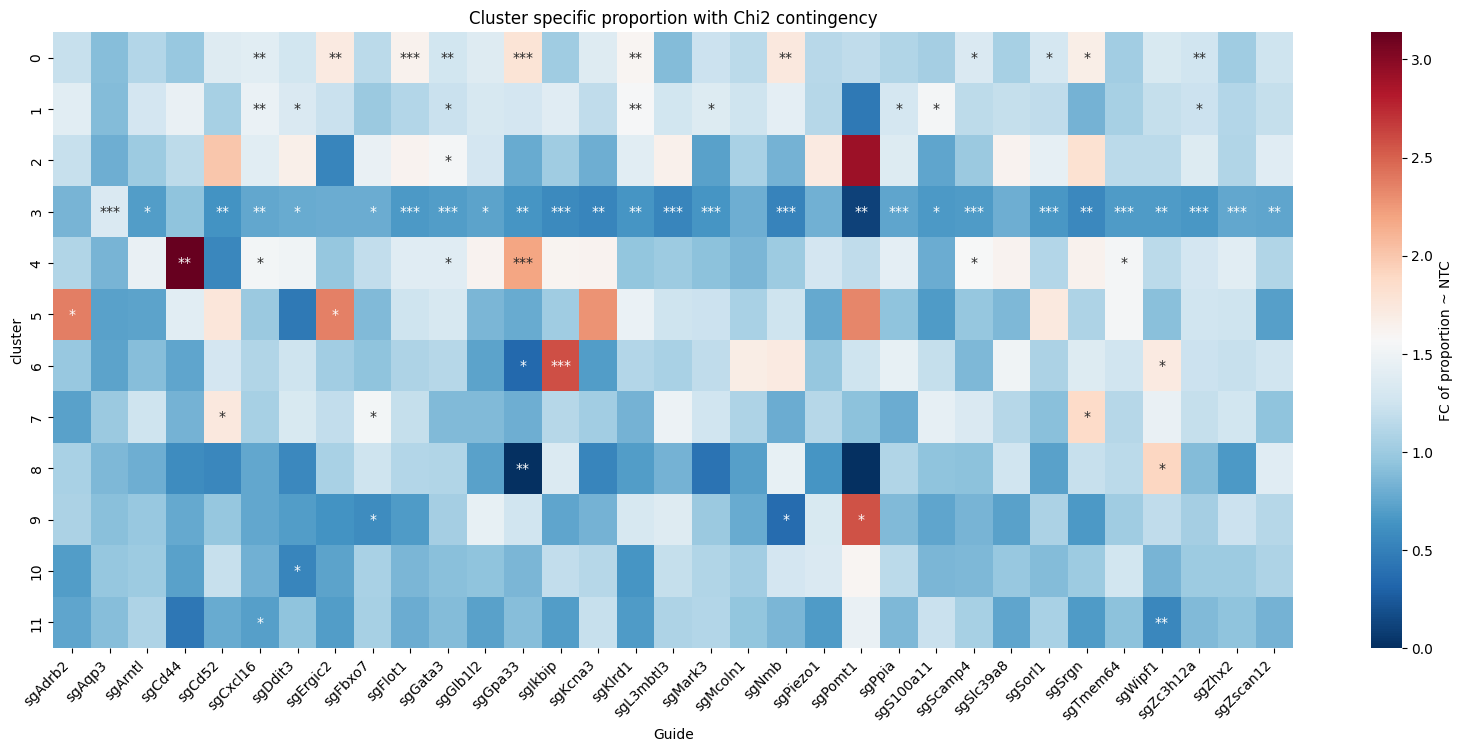

In [123]:
annot_df = chi_df.map(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(pdf, annot=annot_df, fmt='s', cmap='RdBu_r')

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('FC of proportion ~ NTC')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Guide')
plt.title('Cluster specific proportion with Chi2 contingency')
plt.show()

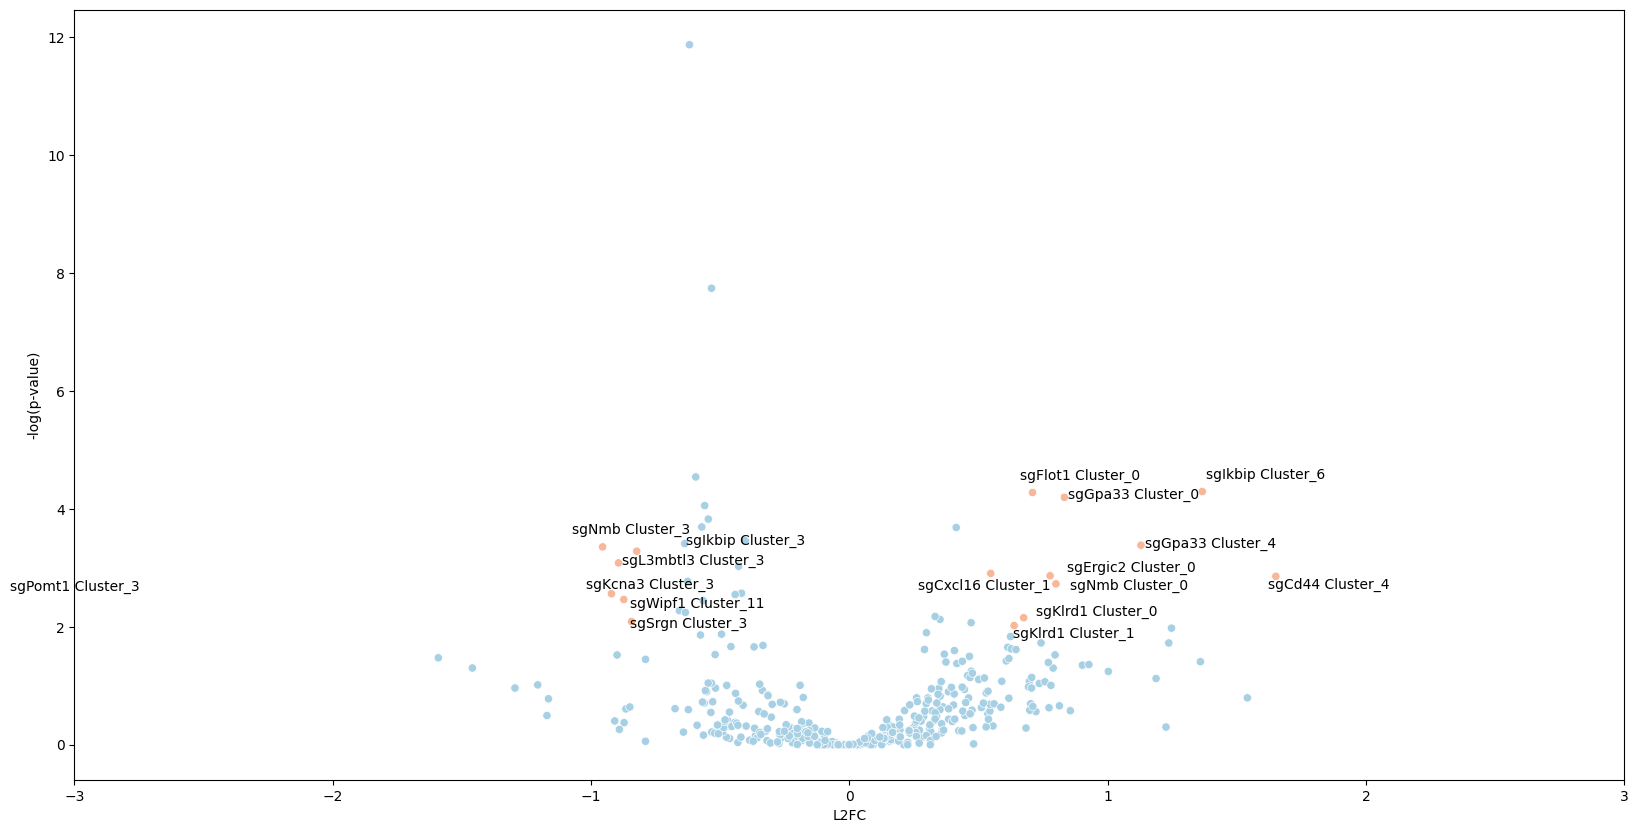

In [182]:
from adjustText import adjust_text


plot_df = pd.DataFrame({
    'p-value': -np.log10(chi_df.melt().value.tolist()),
    'FC': list(np.log2(pdf.melt().value + 1e-9)),
    'Label': list((chi_df.melt().value < 0.01) & (np.abs(1 - pdf.melt().value) > 0.4))
}, index=[str(a) + ' Cluster_' + str(b) for a, b in zip(chi_df.melt().variable, chi_df.melt(ignore_index=False).index)])

plot_df = plot_df[plot_df.FC > np.log2(1e-6)]

# Create scatter plot
plt.figure(figsize=(20, 10))
scatter = sns.scatterplot(data=plot_df, x='FC', y='p-value', hue='Label', palette='RdBu_r', legend=False)

# Add labels for points where 'Label' is True
texts = []
for i, point in plot_df[plot_df['Label']].iterrows():
    texts.append(plt.text(point['FC'], point['p-value'], str(i)))

# Adjust text to prevent overlap
adjust_text(texts, expand_axes=True)

# Set x and y limits and labels
plt.xlim((-3, 3))
plt.xlabel('L2FC')
plt.ylabel('-log(p-value)')

plt.show()